# Productivity and GDP - Data Analysis and Regression Model
__Cam Fraser__ <br>
_27/05/2022 - 08/05/2022_

# Introduction

In [99]:
import numpy as np
import pandas as pd
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns

---
# Data Cleaning

## GDP Estimates

In [273]:
uk_gdp_estimates = pd.read_excel("/Users/cameronfraser/CodeClan/producivity_&_gdp_project/raw_data/data/UK GDP Estimates - Time Series.xlsx", header=0, engine='openpyxl').iloc[6:]

uk_gdp_estimates.rename(columns={
    "Title": "year",
    "Total gross final expenditure (aligned) - P.3+P.5+P.6 : CVM SA £m": "gov_consumption",
    "Household final consumption expenditure :National concept CVM SA - £m": "house_consumption",
    "Total Gross Fixed Capital Formation CVM SA £m": "investment",
    "Balance of Payments: Trade in Goods & Services: Total Balance: CVM SA £m": "net_exports",
    "Gross Domestic Product: chained volume measures: Seasonally adjusted £m": "gdp"
}, inplace=True)


# Have to split this data up, as there is annual and quarterly data within it
uk_gdp_estimates_annual = uk_gdp_estimates[~uk_gdp_estimates["year"].str.contains("Q")][:]
uk_gdp_estimates_quarterly = uk_gdp_estimates[uk_gdp_estimates["year"].str.contains("Q")][:]



/Users/cameronfraser/opt/anaconda3/envs/python39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [101]:
uk_gdp_quarterly_df = uk_gdp_estimates_quarterly.loc[:,("gdp","year","net_exports", "gov_consumption", "house_consumption", "investment")][:]

# Converting quarterly data to datetime

uk_gdp_quarterly_df["quarter"] = uk_gdp_quarterly_df["year"].str.replace(r'(\d+) (Q\d)', r'\2 \1')
uk_gdp_quarterly_df["quarter"] = (
    pd.to_datetime(
        uk_gdp_quarterly_df['quarter'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
))

uk_gdp_quarterly_df.dropna(inplace=True)

/var/folders/nr/2lvpnbdn1vb5_fbkj9m9jbh00000gn/T/ipykernel_66056/3371593944.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  uk_gdp_quarterly_df["quarter"] = uk_gdp_quarterly_df["year"].str.replace(r'(\d+) (Q\d)', r'\2 \1')


In [102]:
uk_gdp_quarterly_df

,gdp,year,net_exports,gov_consumption,house_consumption,investment,quarter
115,0.0,1955 Q2,1091.0,113551.0,63938.0,13901.0,1955-04-01
116,2.0,1955 Q3,1052.0,119670.0,64843.0,14389.0,1955-07-01
117,-0.6,1955 Q4,1297.0,118919.0,64412.0,14706.0,1955-10-01
118,0.9,1956 Q1,1407.0,119429.0,64619.0,14918.0,1956-01-01
119,-0.4,1956 Q2,1866.0,119017.0,64520.0,15205.0,1956-04-01
...,...,...,...,...,...,...,...
364,0.4,2017 Q3,-4240.0,656216.0,316397.0,86111.0,2017-07-01
365,0.3,2017 Q4,-3225.0,657732.0,317486.0,86673.0,2017-10-01
366,-0.1,2018 Q1,-4636.0,657501.0,318604.0,86144.0,2018-01-01
367,0.2,2018 Q2,-6834.0,659885.0,320350.0,85417.0,2018-04-01


In [139]:
uk_labour_prod = pd.read_excel("/Users/cameronfraser/CodeClan/producivity_&_gdp_project/raw_data/data/Uk Labour Productivity - Time Series.xlsx", engine='openpyxl').iloc[6:]

#uk_jobs_per_hour["quarter"] = uk_labour_prod["year"]
uk_labour_prod.rename(columns={
    "Title": "year",
    "Unit Wage Costs : whole economy SA: Index 2016=100: UK": "wages_cost",
}, inplace=True)

uk_labour_prod_vars_interest = uk_labour_prod.loc[:,("year", "wages_cost")][:]

uk_labour_prod_vars_interest_annual = uk_labour_prod_vars_interest[~uk_labour_prod_vars_interest["year"].str.contains("Q")][:]
uk_labour_prod_vars_interest_quarterly = uk_labour_prod_vars_interest[uk_labour_prod_vars_interest["year"].str.contains("Q")][:]

uk_labour_prod_vars_interest_quarterly["quarter"] = uk_labour_prod_vars_interest_quarterly["year"].str.replace(r'(\d+) (Q\d)', r'\2 \1')
uk_labour_prod_vars_interest_quarterly["quarter"] = (
    pd.to_datetime(
        uk_labour_prod_vars_interest_quarterly['quarter'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
))

/Users/cameronfraser/opt/anaconda3/envs/python39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/nr/2lvpnbdn1vb5_fbkj9m9jbh00000gn/T/ipykernel_66056/3705465998.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  uk_labour_prod_vars_interest_quarterly["quarter"] = uk_labour_prod_vars_interest_quarterly["year"].str.replace(r'(\d+) (Q\d)', r'\2 \1')


In [124]:
### Global Finacial Development ###

global_finan_dev = pd.read_excel("/Users/cameronfraser/CodeClan/de13_classnotes/week_12/day_5/final_project_briefs/deloitte_gdp_project/data/Global Financial Development.xlsx", sheet_name="Data - July 2018", engine='openpyxl')

# renaming global finacial development columns for ease of use later on
global_finan_dev.rename(columns={
    "ny_gdp_pcap_kd": "gdp_per_capita",
    "ny_gdp_mktp_cd": "gdp",
    "sp_pop_totl": "population"
}, inplace=True)

# Impute gdp per capita if not there and then filter out any still not there
global_finan_dev["gdp_per_capita"].fillna(global_finan_dev["gdp"]/global_finan_dev["population"], inplace=True)

global_finan_dev

,iso3,iso2,imfn,country,region,income,year,gfddai01,gfddai02,gfddai03,...,gfddoi18,gfddoi19,gfddom01,gfddom02,gfddoe01,gfddoe02,gdp,gdp_per_capita,ny_gnp_mktp_cd,population
0,AFG,AF,512.0,Afghanistan,South Asia,Low income,1960,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,5.400000e+08,60.000000,5.500000e+08,9000000.0
1,AFG,AF,512.0,Afghanistan,South Asia,Low income,1961,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,5.500000e+08,59.782609,5.600000e+08,9200000.0
2,AFG,AF,512.0,Afghanistan,South Asia,Low income,1962,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,5.500000e+08,59.139785,5.600000e+08,9300000.0
3,AFG,AF,512.0,Afghanistan,South Asia,Low income,1963,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,7.500000e+08,78.947368,7.700000e+08,9500000.0
4,AFG,AF,512.0,Afghanistan,South Asia,Low income,1964,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,8.000000e+08,82.474227,8.200000e+08,9700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,ZWE,ZW,698.0,Zimbabwe,Sub-Saharan Africa,Low income,2013,77.9809,12.00350,NaN,...,NaN,NaN,NaN,NaN,108.777,109.079,1.500000e+10,942.039000,1.400000e+10,15000000.0
12408,ZWE,ZW,698.0,Zimbabwe,Sub-Saharan Africa,Low income,2014,86.9774,12.81180,NaN,...,NaN,NaN,NaN,NaN,107.912,108.847,1.600000e+10,939.780000,1.400000e+10,15000000.0
12409,ZWE,ZW,698.0,Zimbabwe,Sub-Saharan Africa,Low income,2015,79.9393,5.16544,NaN,...,NaN,NaN,NaN,NaN,105.243,106.225,1.600000e+10,933.503000,1.400000e+10,16000000.0
12410,ZWE,ZW,698.0,Zimbabwe,Sub-Saharan Africa,Low income,2016,244.0700,5.26014,7.8,...,NaN,NaN,NaN,NaN,104.263,104.561,1.700000e+10,917.564000,1.500000e+10,16000000.0


In [129]:
uk_total_glob_fin_dataset = global_finan_dev[global_finan_dev["country"] == "United Kingdom"]

uk_gdp_per_capita = uk_total_glob_fin_dataset.loc[:,("year", "gdp_per_capita")]

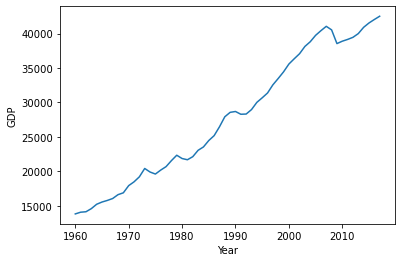

<Figure size 640x480 with 0 Axes>

In [130]:
sns.lineplot(data=uk_gdp_per_capita, x="year", y="gdp_per_capita");
plt.xlabel("Year")
plt.ylabel("GDP")
plt.figure(figsize=(8, 6), dpi=80);

In [122]:
trades_goods_services = pd.read_excel("/Users/cameronfraser/CodeClan/de13_classnotes/week_12/day_5/final_project_briefs/deloitte_gdp_project/additional_data/Trade in good and services - OECD.xlsx")
uk_trades_goods_services = trades_goods_services[(trades_goods_services["LOCATION"] == "GBR") & (trades_goods_services["MEASURE"] == "MLN_USD")]

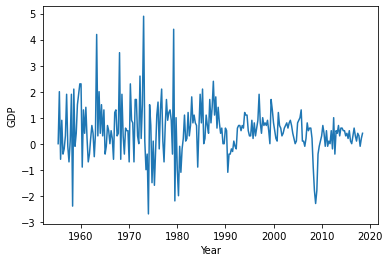

<Figure size 640x480 with 0 Axes>

In [105]:
sns.lineplot(data=uk_gdp_quarterly_df, x="quarter", y="gdp");
plt.xlabel("Year")
plt.ylabel("GDP")
plt.figure(figsize=(8, 6), dpi=80);

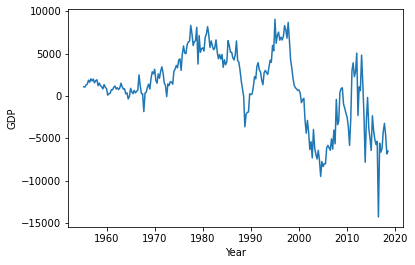

<Figure size 640x480 with 0 Axes>

In [106]:
sns.lineplot(data=uk_gdp_quarterly_df, x="quarter", y="net_exports");
plt.xlabel("Year")
plt.ylabel("GDP")
plt.figure(figsize=(8, 6), dpi=80);

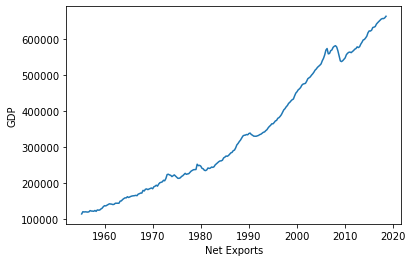

<Figure size 640x480 with 0 Axes>

In [107]:
sns.lineplot(data=uk_gdp_quarterly_df, y="gov_consumption", x="quarter");
plt.xlabel("Net Exports")
plt.ylabel("GDP")
plt.figure(figsize=(8, 6), dpi=80);

---
# Data Analysis

--- 
# Regression Model

In [108]:
uk_gdp_quarterly_df

,gdp,year,net_exports,gov_consumption,house_consumption,investment,quarter
115,0.0,1955 Q2,1091.0,113551.0,63938.0,13901.0,1955-04-01
116,2.0,1955 Q3,1052.0,119670.0,64843.0,14389.0,1955-07-01
117,-0.6,1955 Q4,1297.0,118919.0,64412.0,14706.0,1955-10-01
118,0.9,1956 Q1,1407.0,119429.0,64619.0,14918.0,1956-01-01
119,-0.4,1956 Q2,1866.0,119017.0,64520.0,15205.0,1956-04-01
...,...,...,...,...,...,...,...
364,0.4,2017 Q3,-4240.0,656216.0,316397.0,86111.0,2017-07-01
365,0.3,2017 Q4,-3225.0,657732.0,317486.0,86673.0,2017-10-01
366,-0.1,2018 Q1,-4636.0,657501.0,318604.0,86144.0,2018-01-01
367,0.2,2018 Q2,-6834.0,659885.0,320350.0,85417.0,2018-04-01


In [170]:
### merging data sets to create a model

uk_gdp_estimates_annual["year"] = uk_gdp_estimates_annual["year"].astype(int)
uk_gdp_per_capita["year"] = uk_gdp_per_capita["year"].astype(int)
uk_labour_prod_vars_interest_annual["year"] = uk_labour_prod_vars_interest_annual["year"].astype(int)
uk_gdp_estimates_annual = uk_gdp_estimates_annual.loc[:,("gdp","year","net_exports", "gov_consumption", "house_consumption", "investment")][:]
dataframe_for_model = uk_gdp_per_capita.merge(uk_labour_prod_vars_interest_annual, on="year").merge(uk_gdp_estimates_annual, on="year")
dataframe_for_model.drop(columns="gdp", inplace=True)
dataframe_for_model

,year,gdp_per_capita,wages_cost,net_exports,gov_consumption,house_consumption,investment
0,1960,13827.4,NaN,1569.0,549625.0,295601.0,85965.0
1,1961,14075.9,NaN,3680.0,563132.0,302497.0,92923.0
2,1962,14142.3,NaN,3512.0,570329.0,309528.0,93784.0
3,1963,14592.1,NaN,4267.0,595883.0,323087.0,95983.0
4,1964,15228.0,NaN,218.0,634083.0,334192.0,111528.0
5,1965,15552.5,NaN,2330.0,646197.0,338563.0,116754.0
6,1966,15783.9,NaN,4102.0,658054.0,345080.0,116503.0
7,1967,16061.9,NaN,-102.0,681868.0,354209.0,126672.0
8,1968,16620.9,NaN,3234.0,721915.0,365001.0,140567.0
9,1969,16891.6,NaN,8352.0,734204.0,367691.0,139323.0


In [290]:
corr_matrix_gfd = global_finan_dev.iloc[:,7:].astype(float).corr()
corr_matrix_gfd_gdp_est = pd.DataFrame(uk_gdp_estimates_annual.astype(float).corr())

corr_matrix_gdp_variables = corr_matrix_gfd_gdp_est[(corr_matrix_gfd_gdp_est["gdp"] > 0.4) & (corr_matrix_gfd_gdp_est["gdp"] < 0.9)].index

In [303]:
corr_matrix_gfd_gdp_est[corr_matrix_gfd_gdp_est.columns.str.contains("[Tt]ax")]["gdp"]

PP: Taxes less subsidies on products and production, growth Q on Q                      NaN
PP: Taxes less subsidies on products and production, growth annual                -0.204866
PP: Taxes less subsidies on products and production, growth Q on Q yr ago               NaN
Taxes less subsidies on products and production, cont Q on Q yr ago                     NaN
Taxes less subsidies on products and production, cont annual                      -0.168741
Taxes less subsidies on products and production, cont Q on Q                            NaN
Revision: Taxes less subsidies on products and production, growth Q on Q                NaN
Revision: Taxes less subsidies on products and production, growth Q on Q yr ago         NaN
Revision: Taxes less subsidies on products and production, growth annual           0.369684
Taxes on products & production less subsidies four quarter growth rate %                NaN
Taxes on products & production less subsidies one quarter growth rate %         

In [297]:
variables_with_high_gdp_corr = ["gdp","Trade in services:Balance:Total:CP:SA:£m","Gross Fixed Capital Formation :Total Economy:Total Transport Equipment: CP SA ", "Gross Fixed Capital Formation: Business Investment: CVM SA: £m"]
variables_with_high_gdp_corr

['gdp',
 'Trade in services:Balance:Total:CP:SA:£m',
 'Gross Fixed Capital Formation :Total Economy:Total Transport Equipment: CP SA ',
 'Gross Fixed Capital Formation: Business Investment: CVM SA: £m']

In [ ]:
from sklearn.linear_model import LinearRegression

dataframe_for_model.dropna(inplace=True)

#uk_gdp_quarterly_df["quarter_continuous"] = list(np.arange(1955.25,2018.75, 0.25))
#uk_gdp_quarterly_df = uk_gdp_quarterly_df.drop(columns={"year", "quarter"})

# set the response dataset 
response_var = dataframe_for_model["gdp"][:]

# put our predictors in a data frame
predictor_vars = dataframe_for_model[variables_with_high_gdp_corr]

model = LinearRegression()

model.fit(predictor_vars, response_var)

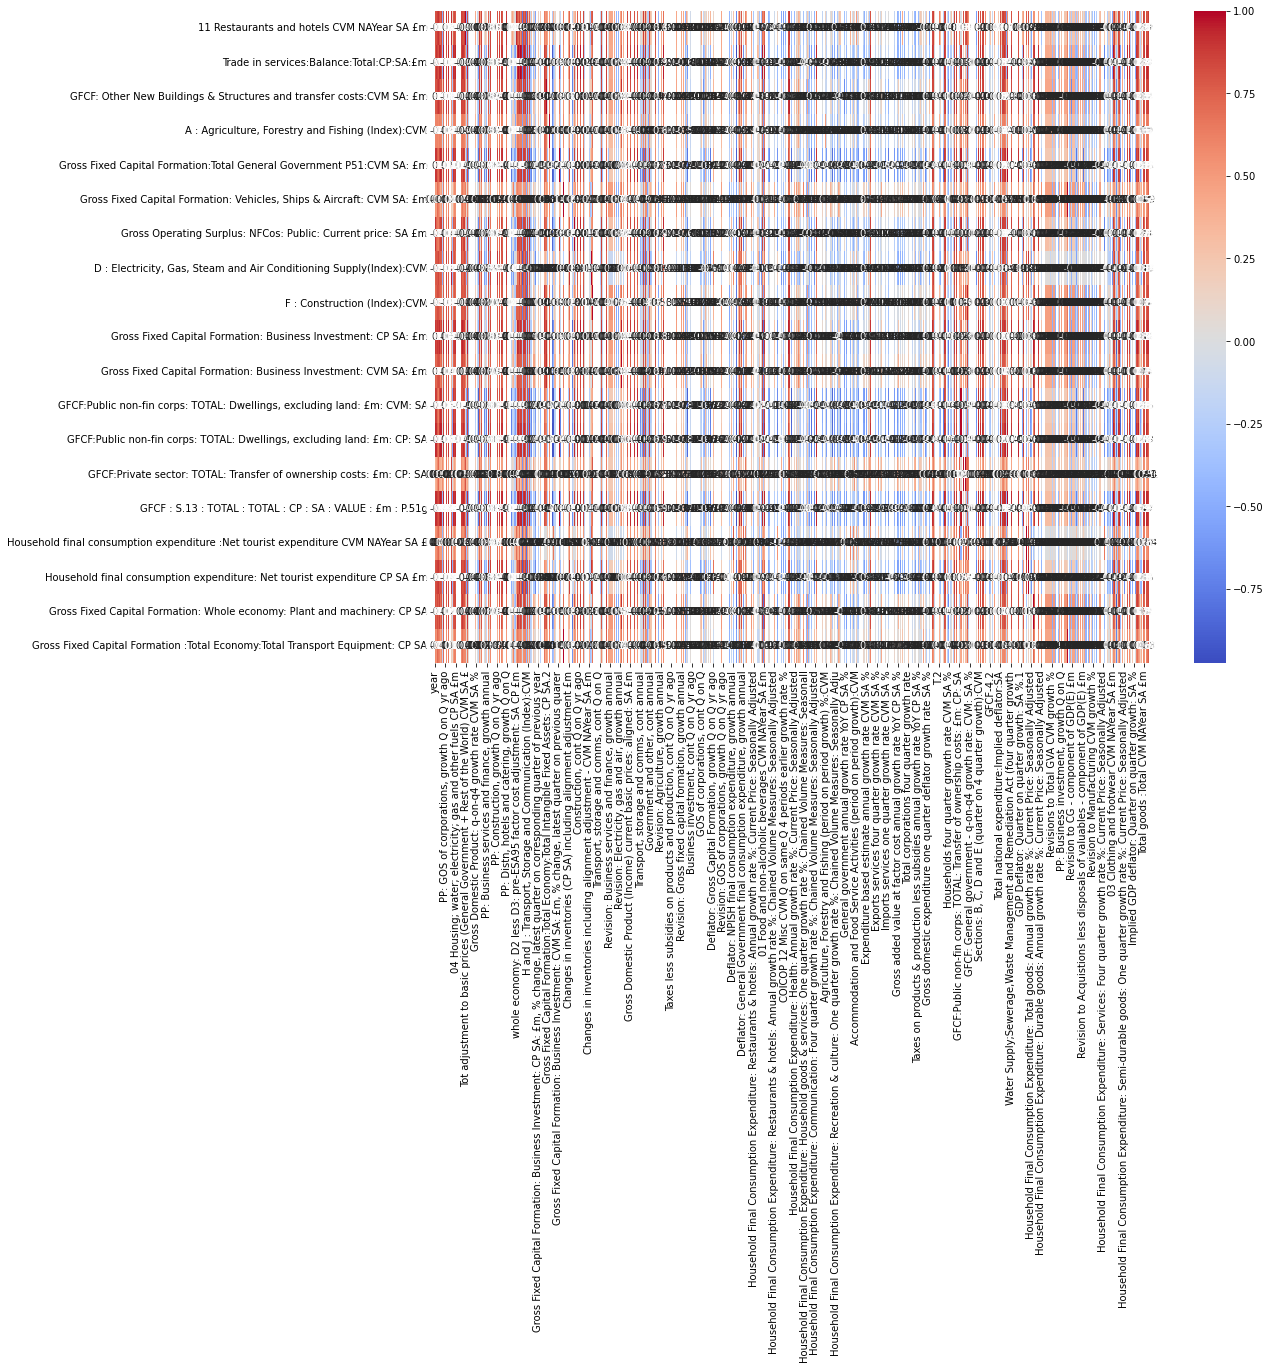

In [283]:
#plt.figure(figsize=(16,12))
#sns.heatmap(data=corr_matrix_gdp_good_level,annot=True,fmt='.2f',cmap='coolwarm')
#plt.show()

In [269]:


corr_matrix_gfd_gdp_est[corr_matrix_gfd_gdp_est["gdp"].abs().sort_values() > 0.5]


/var/folders/nr/2lvpnbdn1vb5_fbkj9m9jbh00000gn/T/ipykernel_66056/2221924813.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_matrix_gfd_gdp_est[corr_matrix_gfd_gdp_est["gdp"].abs().sort_values() > 0.5]


,year,05 Furnishings; household equipment & routine maintnce of the house CVM NAYear £,04 Housing; water; electricity; gas and other fuels CVM NAYear SA £m,05 Furnishings; household equipment and routine maintenance of the house CP SA £,07 Transport CVM NAYear SA £m,07 Transport CP SA £m,General Government: Final consumption expenditure (P3): CPSA £m,Gross Value Added at basic prices: Implied deflator:SA:2017=100,06 Health CVM NAYear SA £m,Gross value added at basic prices annual deflator growth rate SA %,...,ESA95 % change on previous quarter: Gross value added at basic prices,CII: VPI:Manufacturing Total: CVM SA £m,"Gross Domestic Product at market prices, q-on-q4 growth: CP: NSA £m",Gross value added at basic prices:CVM:Index:SA,Total goods :Total CVM NAYear SA £m,"Gross Domestic Product at market prices, q-on-q1 growth: CP: NSA £m",Total goods: Total CP SA £m,Income based: Gross value added at factor cost: CP SA £m,Durable goods :Total CVM NAYear SA £m,Durable goods: Total CP SA £m
year,1.000000,0.938958,0.996416,0.979713,0.955156,0.996062,0.924165,0.983894,0.959694,-0.377564,...,-0.260270,0.113682,NaN,0.986962,0.984927,NaN,0.998839,0.940162,0.974061,0.977576
05 Furnishings; household equipment & routine maintnce of the house CVM NAYear £,0.938958,1.000000,0.948632,0.980458,0.982127,0.937888,0.918200,0.920344,0.894936,-0.591878,...,-0.276071,-0.022418,NaN,0.973612,0.970108,NaN,0.944391,0.942240,0.940461,0.971321
04 Housing; water; electricity; gas and other fuels CVM NAYear SA £m,0.996416,0.948632,1.000000,0.980146,0.961847,0.993432,0.990161,0.987514,0.957897,-0.598603,...,-0.371233,0.062381,NaN,0.992664,0.991295,NaN,0.996382,0.996600,0.975853,0.977216
05 Furnishings; household equipment and routine maintenance of the house CP SA £,0.979713,0.980458,0.980146,1.000000,0.979968,0.979912,0.954930,0.964246,0.955282,-0.615035,...,-0.296014,0.153262,NaN,0.989816,0.983402,NaN,0.984213,0.981210,0.975731,0.997004
07 Transport CVM NAYear SA £m,0.955156,0.982127,0.961847,0.979968,1.000000,0.961645,0.931922,0.934182,0.917512,-0.549365,...,-0.277062,0.082028,NaN,0.984396,0.976147,NaN,0.960709,0.958872,0.959276,0.982532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total goods :Total CVM NAYear SA £m,0.984927,0.970108,0.991295,0.983402,0.976147,0.986256,0.984872,0.964364,0.951549,-0.572942,...,-0.344339,-0.019614,NaN,0.996155,1.000000,NaN,0.987859,0.988945,0.983529,0.980059
Total goods: Total CP SA £m,0.998839,0.944391,0.996382,0.984213,0.960709,0.998230,0.985847,0.986618,0.967123,-0.614655,...,-0.343689,0.132911,NaN,0.991365,0.987859,NaN,1.000000,0.998372,0.980927,0.983292
Income based: Gross value added at factor cost: CP SA £m,0.940162,0.942240,0.996600,0.981210,0.958872,0.997199,0.995011,0.971981,0.970128,-0.497991,...,-0.240396,0.096341,NaN,0.976995,0.988945,NaN,0.998372,1.000000,0.984018,0.980965
Durable goods :Total CVM NAYear SA £m,0.974061,0.940461,0.975853,0.975731,0.959276,0.984657,0.974298,0.944580,0.984826,-0.519462,...,-0.308808,0.099341,NaN,0.979227,0.983529,NaN,0.980927,0.984018,1.000000,0.982100


In [271]:
corr_matrix_gfd_gdp_est["gdp"].abs().sort_values() > 0.5

Change in Inventories: Electricity, Gas & Water: £M: CVM NAYear: SA £m             False
PP: Water and sewerage, growth annual                                              False
PP: Total Production, growth annual                                                False
Manufacturing, cont annual                                                         False
Distribution, hotels and restaurants (period on period growth):CVM                 False
                                                                                   ...  
Implied GDP deflator: Quarter on quarter growth: SA %                              False
Implied GDP deflator at market prices: SA Index                                    False
ESA95 % change on same quarter previous year: Gross value added at basic prices    False
Gross Domestic Product at market prices, q-on-q4 growth: CP: NSA £m                False
Gross Domestic Product at market prices, q-on-q1 growth: CP: NSA £m                False
Name: gdp, Length: 83

In [172]:
from sklearn.linear_model import LinearRegression

dataframe_for_model.dropna(inplace=True)

#uk_gdp_quarterly_df["quarter_continuous"] = list(np.arange(1955.25,2018.75, 0.25))
#uk_gdp_quarterly_df = uk_gdp_quarterly_df.drop(columns={"year", "quarter"})

# set the response dataset 
response_var = dataframe_for_model["gdp"][:]

# put our predictors in a data frame
predictor_vars = dataframe_for_model.drop(columns = {"gdp_per_capita", "house_consumption", "investment","gov_consumption", "net_exports", "year"})[:]


model = LinearRegression()

model.fit(predictor_vars, response_var)

KeyError: 'gdp'

In [173]:
import statsmodels.api as sm

# add in the constant to the data
predictor_vars = sm.add_constant(predictor_vars)
predictor_vars.head()

sm_model = sm.OLS(response_var.astype(float), predictor_vars.astype(float)).fit()
print(sm_model.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

---
# Predicting GDP